In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


# Move to current working directory
%cd drive/MyDrive/The_Turing_Lens/data_v2

Mounted at /content/drive
/content/drive/MyDrive/The_Turing_Lens/data_v2


In [2]:
# Import all the packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import torchvision.datasets as dset
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import ConfusionMatrixDisplay
from PIL import Image
import seaborn as sns


In [3]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print(device)

cuda


# 讀取模型

In [4]:
PATH = 'resnet50_finetuned_weights_0325_6_800.pth'
model = models.resnet50(pretrained=True)
num_flatten = model.fc.in_features
model.fc = nn.Linear(num_flatten, 4)

model.load_state_dict(torch.load(PATH))
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 195MB/s]


In [5]:
# Load data
test_data = dset.ImageFolder('test')
NUM_TEST = len(test_data)
print("NUM_TEST:", NUM_TEST)

SIZE_BEFORE_CUT = 500
CENTER_CROP = 448

# 把原圖的短邊調整為SIZE_BEFORE_CUT，並且保持原圖比例縮小或放大
# 一樣依照原圖比例centercrop，短邊先調整為CENTER_CROP，保持原圖比例進行centercrop
def img_transform(data, mode='None'):
  w, h = data[0].size
  y = data[1]
  if w < h:
    new_img = data[0].resize((SIZE_BEFORE_CUT, int((SIZE_BEFORE_CUT/w) * h))) # 先依照比例resize (短邊 == SIZE_BEFORE_CUT)

    # 計算等等要center_crop的尺寸
    new_w, new_h = new_img.size
    center_crop_w = CENTER_CROP
    center_crop_h = int((CENTER_CROP/new_w) * new_h)
  else:
    new_img = data[0].resize((int((SIZE_BEFORE_CUT/h) * w), SIZE_BEFORE_CUT))
    new_w, new_h = new_img.size
    center_crop_w = int((CENTER_CROP/new_h) * new_w)
    center_crop_h = CENTER_CROP


  transform_tensor = T.Compose([T.CenterCrop((center_crop_h, center_crop_w)), T.ToTensor()])
  transform_centercrop = T.Compose([T.CenterCrop((center_crop_h, center_crop_w))])

  if mode == 'tensor':
    return transform_tensor(new_img), torch.tensor(y)
  else:
    return transform_centercrop(new_img)


# 確認第一張照片的尺寸是否有維持原比例以及對應的true label
new_img = img_transform(test_data[0], mode='tensor')
img, y = new_img
print(img.shape, y)

NUM_TEST: 140
torch.Size([3, 596, 448]) tensor(0)


In [6]:
bad_prediction_test = []
acc_count_test = 0
model.eval()
with torch.no_grad():
  for i in range(len(test_data)): # 使用每張每張圖片進去預測
    print(f'Running...{i+1}/{NUM_TEST}')
    new_img, y = img_transform(test_data[i], mode='tensor') # 按照原圖比例縮小，並得到x, y

    '''
    new_img.shape == torch.Size([3, 597, 448])
    但是.to(device)時，輸入進去的尺寸應該要是torch.Size([1, 3, 597, 448]) (N x C x H x W), N=1(每次一張圖片)
    因此先做升維的動作new_img.unsqueeze(0)，此時new_img.unsqueeze(0).shape == torch.Size([1, 3, 597, 448])
    '''
    x_score_test = new_img.unsqueeze(0).to(device)
    y_score_test = y.unsqueeze(0).to(device)

    score_test = model(x_score_test)
    predictions=score_test.max(1)[1]

    acc_count_test += 1 if predictions == y_score_test else 0
    rate = torch.softmax(score_test, dim=1)

    # 記錄預測後的數據
    bad_prediction_test.append(
        dict(
            y_label=y_score_test.item(),
            prediction=predictions.item(),
            Portrait=rate[0][0].item(),
            Midjourney=rate[0][1].item(),
            SD=rate[0][2].item(),
            Bing=rate[0][3].item()
        )
    )

  print(f"測試資料正確率: {acc_count_test / NUM_TEST}")

Running...1/140
Running...2/140
Running...3/140
Running...4/140
Running...5/140
Running...6/140
Running...7/140
Running...8/140
Running...9/140
Running...10/140
Running...11/140
Running...12/140
Running...13/140
Running...14/140
Running...15/140
Running...16/140
Running...17/140
Running...18/140
Running...19/140
Running...20/140
Running...21/140
Running...22/140
Running...23/140
Running...24/140
Running...25/140
Running...26/140
Running...27/140
Running...28/140
Running...29/140
Running...30/140
Running...31/140
Running...32/140
Running...33/140
Running...34/140
Running...35/140
Running...36/140
Running...37/140
Running...38/140
Running...39/140
Running...40/140
Running...41/140
Running...42/140
Running...43/140
Running...44/140
Running...45/140
Running...46/140
Running...47/140
Running...48/140
Running...49/140
Running...50/140
Running...51/140
Running...52/140
Running...53/140
Running...54/140
Running...55/140
Running...56/140
Running...57/140
Running...58/140
Running...59/140
Runnin

In [7]:
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_rows', 140)
test_d = pd.DataFrame(bad_prediction_test)
test_d.loc[test_d.y_label == test_d.prediction, 'check'] ='T'
test_d
# {'0': Portrait, '1': midjourney, '2': sd, '3':bing}

,y_label,prediction,Portrait,Midjourney,SD,Bing,check
0,0,0,1.0000,0.0000,0.0000,0.0000,T
1,0,0,1.0000,0.0000,0.0000,0.0000,T
2,0,0,1.0000,0.0000,0.0000,0.0000,T
3,0,0,1.0000,0.0000,0.0000,0.0000,T
4,0,0,1.0000,0.0000,0.0000,0.0000,T
5,0,2,0.0033,0.0000,0.9967,0.0000,NaN
6,0,0,1.0000,0.0000,0.0000,0.0000,T
7,0,0,0.9907,0.0000,0.0093,0.0000,T
8,0,0,1.0000,0.0000,0.0000,0.0000,T
9,0,0,1.0000,0.0000,0.0000,0.0000,T


In [8]:
output_rate = test_d.copy()

output_rate.loc[output_rate.check.isna(), 'check'] = 'F'
output_rate['y_label'].replace({0: 'Portrait', 1: 'Midjourney', 2: 'SD', 3: 'Bing'}, inplace=True)
output_rate['prediction'].replace({0: 'Portrait', 1: 'Midjourney', 2: 'SD', 3: 'Bing'}, inplace=True)

output_rate.to_csv('resnet50_finetuned_weights_0325_6_800_output.csv', sep='\t')
print(output_rate)

        y_label  prediction  Portrait  Midjourney     SD   Bing check
0      Portrait    Portrait    1.0000      0.0000 0.0000 0.0000     T
1      Portrait    Portrait    1.0000      0.0000 0.0000 0.0000     T
2      Portrait    Portrait    1.0000      0.0000 0.0000 0.0000     T
3      Portrait    Portrait    1.0000      0.0000 0.0000 0.0000     T
4      Portrait    Portrait    1.0000      0.0000 0.0000 0.0000     T
5      Portrait          SD    0.0033      0.0000 0.9967 0.0000     F
6      Portrait    Portrait    1.0000      0.0000 0.0000 0.0000     T
7      Portrait    Portrait    0.9907      0.0000 0.0093 0.0000     T
8      Portrait    Portrait    1.0000      0.0000 0.0000 0.0000     T
9      Portrait    Portrait    1.0000      0.0000 0.0000 0.0000     T
10     Portrait    Portrait    1.0000      0.0000 0.0000 0.0000     T
11     Portrait    Portrait    1.0000      0.0000 0.0000 0.0000     T
12     Portrait    Portrait    0.9770      0.0230 0.0000 0.0000     T
13     Portrait    P

# **Confusion Matrix**

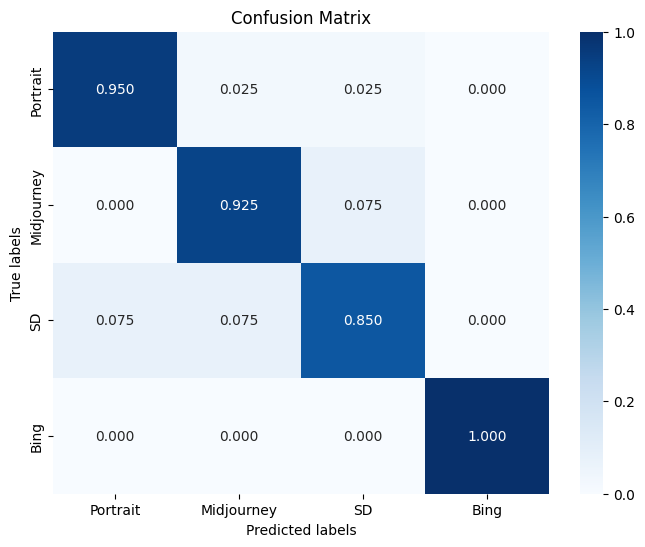

In [9]:
y_true = test_d.y_label
y_pred = test_d.prediction

conf_matrix = cm(y_true, y_pred, normalize='true') # 顯示佔比
plt.figure(figsize=(8, 6))
num_classes = ['Portrait', 'Midjourney', 'SD', 'Bing']
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=num_classes, yticklabels=num_classes, fmt='.3f')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [10]:
bad_pred_index = test_d[test_d.check.isna()].index
print('錯誤分類的index:', bad_pred_index)
print('錯誤分類的數量:', len(bad_pred_index))

錯誤分類的index: Int64Index([5, 29, 70, 71, 73, 80, 90, 96, 97, 100, 106], dtype='int64')
錯誤分類的數量: 11


In [12]:
col = 3
row = len(bad_pred_index) // col + 1

mapping = {0: 'Portrait', 1: 'Midjourney', 2: 'SD', 3: 'Bing'}

fig, axes = plt.subplots(row, col, figsize=(18, row*5))
for i, ax in enumerate(axes.flat):
  if i < len(bad_pred_index):

    # 獲取每張圖片預測的機率數值
    rate_d = {
        'Portrait': test_d.Portrait.loc[bad_pred_index[i]],
        'Midjourney': test_d.Midjourney.loc[bad_pred_index[i]],
        'SD': test_d.SD.loc[bad_pred_index[i]],
        'Bing': test_d.Bing.loc[bad_pred_index[i]]
    }

    # 取得照片
    img = test_data[bad_pred_index[i]][0]
    ax.imshow(img)
    ax.axis('off')

    # 取得y_label的字串
    y_label = mapping[test_d.y_label[bad_pred_index[i]]]

    # 取得模型預測的字串
    pred = mapping[test_d.prediction[bad_pred_index[i]]]
    ax.set_title('y_label : ' + y_label + ' , ' + 'pred : ' + pred + '(' + str("{:.3f}".format(rate_d[pred])) + ')', fontsize=15, y=-0.08)
  else:
    ax.axis('off')

plt.tight_layout()
plt.show()

# **Saliency Map**

Reference : https://medium.datadriveninvestor.com/visualizing-neural-networks-using-saliency-maps-in-pytorch-289d8e244ab4


In [14]:
def saliency_map(img, model):
  x, _ = img_transform(img, mode='tensor')
  x = x.to(device).unsqueeze(0)
  x.requires_grad_()
  output = model(x)
  output_max = torch.argmax(output, dim=1)
  model.zero_grad()
  output[0, output_max].backward()

  saliency, _ = torch.max(x.grad.data.abs(), dim=1)

  return saliency[0]

In [15]:
saliency_map_lst = []
original_img_lst = []
for i in range(len(test_data)):
  # 取得Saliency map
  sm_img = saliency_map(test_data[i], model)
  saliency_map_lst.append(sm_img)
  # 取得原圖
  img = img_transform(test_data[i])
  original_img_lst.append(img)

# 確認saliency_map_lst的照片大小
print('saliency_map:', saliency_map_lst[0].shape) # (H, W)
# 確認original_img_lst的照片大小
print('original_img:', original_img_lst[0].size) # (W, H)

saliency_map: torch.Size([596, 448])
original_img: (448, 596)


In [20]:
col = 2
row = len(saliency_map_lst)

fig, axes = plt.subplots(row, col, figsize=(8, row*3))
for i in range(len(saliency_map_lst)):
  # 畫出Saliency map
  ax = axes[i, 0]
  ax.set_title(f'Y_label : {output_rate.y_label[i]}, Pred : {output_rate.prediction[i]} ({output_rate[str(output_rate.prediction[i])].loc[i]})', fontsize=8, y=-0.1)
  ax.imshow(saliency_map_lst[i].cpu().numpy(), cmap=plt.cm.hot)
  ax.axis('off')

  # 畫出原圖(有經過center_crop的)
  ax = axes[i, 1]
  ax.imshow(original_img_lst[i])
  ax.axis('off')

plt.show()



# 顯示錯誤分類的Saliency map

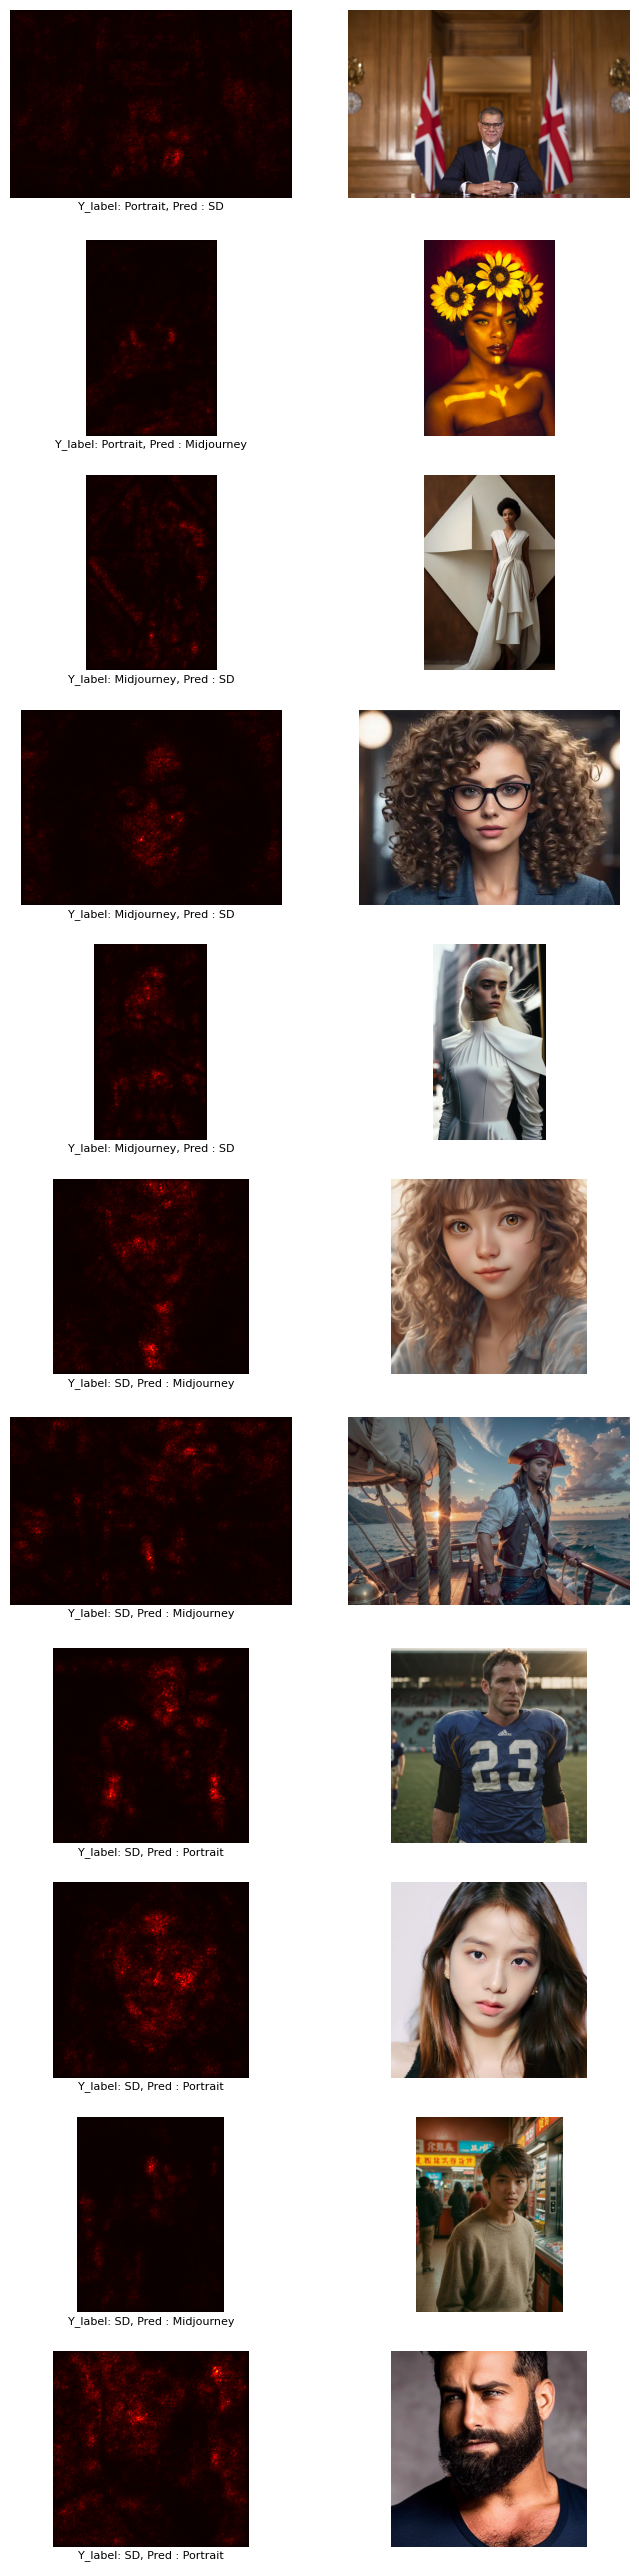

In [23]:
col = 2
row = len(bad_pred_index)

fig, axes = plt.subplots(row, col, figsize=(8, row*3))
for i in range(len(bad_pred_index)):
  # 畫出Saliency map
  ax = axes[i, 0]
  ax.set_title(f'Y_label: {output_rate.y_label[bad_pred_index[i]]}, Pred : {output_rate.prediction[bad_pred_index[i]]}', fontsize=8, y=-0.1)
  ax.imshow(saliency_map_lst[bad_pred_index[i]].cpu().numpy(), cmap=plt.cm.hot)
  ax.axis('off')

  # 畫出原圖(有經過center_crop的)
  ax = axes[i, 1]
  ax.imshow(original_img_lst[bad_pred_index[i]])
  ax.axis('off')

# 2X2 Confusion Matrix

使用4元分類器，確認AI跟非AI的預測狀況是如何。

mapping = {0: 非AI, 1: AI}

In [17]:
cm_22_data = test_d.copy()
cm_22_data

,y_label,prediction,Portrait,Midjourney,SD,Bing,check
0,0,0,1.0000,0.0000,0.0000,0.0000,T
1,0,0,1.0000,0.0000,0.0000,0.0000,T
2,0,0,1.0000,0.0000,0.0000,0.0000,T
3,0,0,1.0000,0.0000,0.0000,0.0000,T
4,0,0,1.0000,0.0000,0.0000,0.0000,T
5,0,2,0.0033,0.0000,0.9967,0.0000,NaN
6,0,0,1.0000,0.0000,0.0000,0.0000,T
7,0,0,0.9907,0.0000,0.0093,0.0000,T
8,0,0,1.0000,0.0000,0.0000,0.0000,T
9,0,0,1.0000,0.0000,0.0000,0.0000,T


In [18]:
# 如果原圖是0 (非AI)，預測成1, 2或3 (其他的AI照片), 算當筆預測錯誤
cm_22_data.loc[(cm_22_data.y_label == 0) & (cm_22_data.prediction != 0), 'prediction'] = 1

# 如果原圖是1 (AI)，預測成0 (portrait, 非AI), 算當筆預測錯誤
cm_22_data.loc[(cm_22_data.y_label == 1) & (cm_22_data.prediction == 0), 'prediction'] = 0
# 如果原圖是1 (AI)，預測成1, 2或3 (其他的AI照片), 都算預測成功
cm_22_data.loc[(cm_22_data.y_label == 1) & (cm_22_data.prediction != 0), 'prediction'] = 1

# 如果原圖是2 (AI)，預測成0 (portrait, 非AI), 算當筆預測錯誤
cm_22_data.loc[(cm_22_data.y_label == 2) & (cm_22_data.prediction == 0), 'prediction'] = 0
# 如果原圖是2 (AI)，預測成1, 2或3 (其他的AI照片), 都算預測成功
cm_22_data.loc[(cm_22_data.y_label == 2) & (cm_22_data.prediction != 0), 'prediction'] = 1

# 如果原圖是3 (AI)，預測成0 (portrait, 非AI), 算當筆預測錯誤
cm_22_data.loc[(cm_22_data.y_label == 3) & (cm_22_data.prediction == 0), 'prediction'] = 0
# 如果原圖是3 (AI)，預測成1, 2或3 (其他的AI照片), 都算預測成功
cm_22_data.loc[(cm_22_data.y_label == 3) & (cm_22_data.prediction != 0), 'prediction'] = 1

# 把全部AI繪圖的y_label都改為1
cm_22_data.loc[(cm_22_data.y_label != 0), 'y_label'] = 1

cm_22_data

,y_label,prediction,Portrait,Midjourney,SD,Bing,check
0,0,0,1.0000,0.0000,0.0000,0.0000,T
1,0,0,1.0000,0.0000,0.0000,0.0000,T
2,0,0,1.0000,0.0000,0.0000,0.0000,T
3,0,0,1.0000,0.0000,0.0000,0.0000,T
4,0,0,1.0000,0.0000,0.0000,0.0000,T
5,0,1,0.0033,0.0000,0.9967,0.0000,NaN
6,0,0,1.0000,0.0000,0.0000,0.0000,T
7,0,0,0.9907,0.0000,0.0093,0.0000,T
8,0,0,1.0000,0.0000,0.0000,0.0000,T
9,0,0,1.0000,0.0000,0.0000,0.0000,T


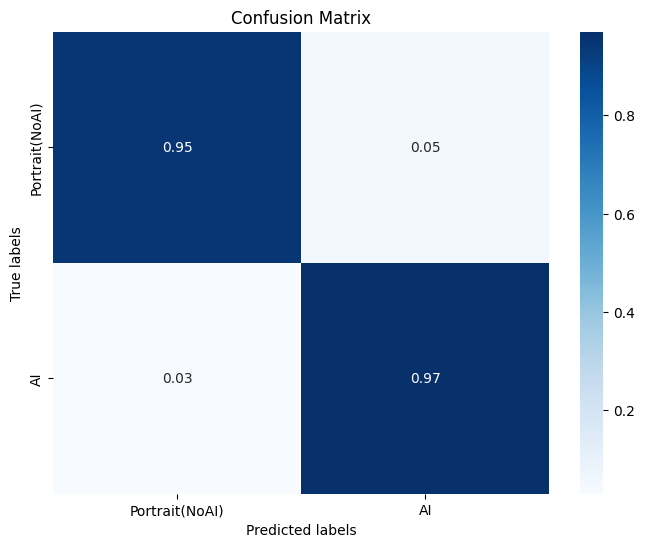

In [19]:
y_true = cm_22_data.y_label
y_pred = cm_22_data.prediction

conf_matrix = cm(y_true, y_pred, normalize='true')
plt.figure(figsize=(8, 6))
num_classes = ['Portrait(NoAI)', 'AI']
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=num_classes, yticklabels=num_classes)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()